## Use daily infected only
### GRU and LSTM

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf



In [2]:
df = pd.read_csv('../seir/cov_datasets/pcr_positive_daily_Sep18.csv')
df['Date'] = pd.to_datetime(df['Date'])
print(df.shape)
print(df.dtypes)
df.head()

(611, 2)
Date        datetime64[ns]
Infected           float64
dtype: object


,Date,Infected
0,2020-01-16,1.0
1,2020-01-17,0.0
2,2020-01-18,0.0
3,2020-01-19,0.0
4,2020-01-20,0.0


In [3]:
training_set = df['Infected'][:500].values.astype(int)
test_set = df['Infected'][500:].values.astype(int)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set.reshape(len(training_set), 1))
testing_set_scaled = sc.fit_transform(test_set.reshape(len(test_set), 1))


# Creating a data structure with 5 time-steps and 2 output
X_train = []
y_train = []

X_test = []
y_test = []


In [4]:
print(training_set_scaled.shape)
print(testing_set_scaled.shape)

(500, 1)
(111, 1)


In [5]:
611-594

17

In [6]:
def split_seq(sequence, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(len(sequence)):
        end_idx = i + n_steps_in
        steps_out_idx = end_idx + n_steps_out
        
        #check if we reach end of arr or not
        if (steps_out_idx > len(sequence)):
            break
        seq_x = sequence[i:end_idx]
        seq_y = sequence[end_idx:steps_out_idx]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
n_steps_in = 14
n_steps_out = 4

X_train , y_train = split_seq(training_set_scaled, n_steps_in, n_steps_out)
X_test , y_test = split_seq(testing_set_scaled, n_steps_in, n_steps_out)

In [8]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(483, 14, 1) (483, 4, 1)
(94, 14, 1) (94, 4, 1)


In [9]:
input_shape = (X_train.shape[1],X_train.shape[2])
input_shape

(14, 1)

### LSTM

In [17]:
model_lstm = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))

# Adding a second LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units = 50, return_sequences = True))

# Adding a third LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units = 50, return_sequences = True))

# Adding a fourth LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units = 50))

# Adding the output layer
model_lstm.add(Dense(units = n_steps_out))

# Compiling the RNN
model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model_lstm.fit(X_train, y_train, epochs = 1000, batch_size = 32, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Epoch 1/1000
16/16 [==============================] - 2s 104ms/step - loss: 0.0388 - val_loss: 0.0608
Epoch 2/1000
16/16 [==============================] - 0s 17ms/step - loss: 0.0472 - val_loss: 0.0533
Epoch 3/1000
16/16 [==============================] - 0s 15ms/step - loss: 0.0191 - val_loss: 0.0555
Epoch 4/1000
16/16 [==============================] - 0s 17ms/step - loss: 0.0296 - val_loss: 0.0604
Epoch 5/1000
16/16 [==============================] - 0s 16ms/step - loss: 0.0130 - val_loss: 0.0424
Epoch 6/1000
16/16 [==============================] - 0s 17ms/step - loss: 0.0146 - val_loss: 0.0457
Epoch 7/1000
16/16 [==============================] - 0s 17ms/step - loss: 0.0110 - val_loss: 0.0419
Epoch 8/1000
16/16 [==============================] - 0s 20ms/step - loss: 0.0114 - val_loss: 0.0417
Epoch 9/1000
16/16 [==============================] - 0s 18ms/step - loss: 0.0109 - val_loss: 0.0412
Epoch 10/1000
16/16 [==============================] - 0s 17ms/step - loss: 0.0109 - val_l

In [18]:
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = sc.inverse_transform(y_pred_lstm) #revert scaling

In [19]:
y_pred_lstm.shape

(94, 4)

In [20]:
#y_pred_lstm

In [21]:
y_test.shape

(94, 4, 1)

In [22]:
y_test_reshape = sc.inverse_transform(y_test.reshape(len(y_test), 4))
#y_test_reshape

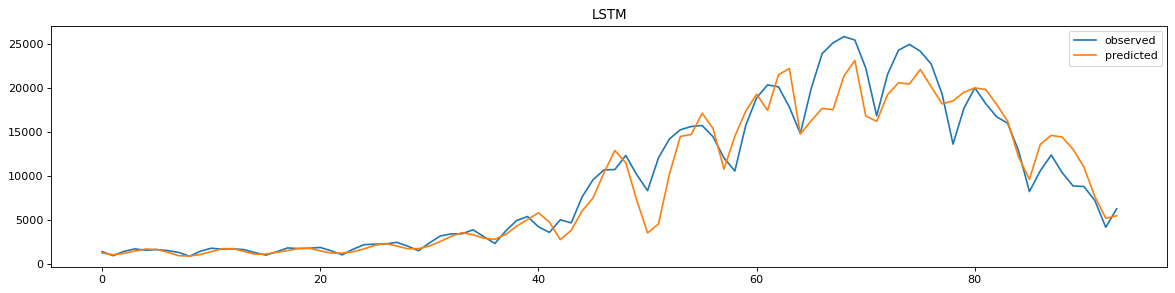

In [23]:
from matplotlib.pyplot import figure
figure(figsize=(18, 4), dpi=80)

plt.plot(y_test_reshape[:,0], label='observed')
plt.plot(y_pred_lstm[:,0], label='predicted')
plt.title('LSTM')
plt.legend()
plt.show()

In [24]:
mean_squared_error(y_test_reshape, y_pred)

7408334.888258249

In [25]:
df[-14:]

,Date,Infected
597,2021-09-04,15997.0
598,2021-09-05,12890.0
599,2021-09-06,8223.0
600,2021-09-07,10586.0
601,2021-09-08,12384.0
602,2021-09-09,10378.0
603,2021-09-10,8869.0
604,2021-09-11,8793.0
605,2021-09-12,7204.0
606,2021-09-13,4161.0


### Rescaling input before feeding to model

In [26]:
x_input = np.array([8793.0,7204.0,4161.0,6262, 6799, 5692, 5091, 4692, 3395, 2219, 1758, 3229, 3598, 2085])

In [27]:
#x_input = np.array(df['Infected'][-14:]) # the lastest 14 days
x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
x_input = x_input.reshape((1, n_steps_in, 1))
print(x_input.shape)

(1, 14, 1)


In [56]:
y_pred2 = model_lstm.predict(x_input)
y_pred2 = sc.inverse_transform(y_pred2) #revert scaling

In [57]:
y_pred2.shape

(1, 4)

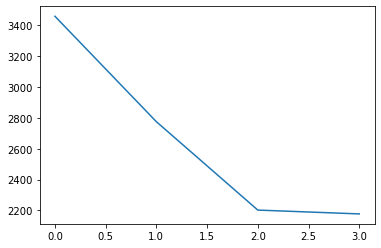

In [58]:
plt.plot(y_pred2[0,:])

In [59]:
x_input_raw = np.array([8793.0,7204.0,4161.0,6262, 6799, 5692, 5091, 4692, 3395, 2219, 1758, 3229, 3598, 2085])
len(x_input_raw)

14

In [60]:
time_range = pd.date_range(start='2021-09-11', end='2021-09-28')

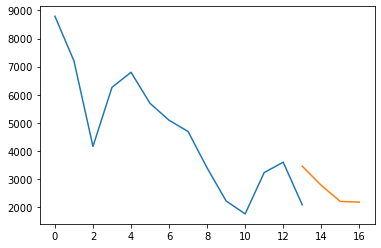

In [61]:
len_x_input = len(x_input_raw)
plt.plot(range(0,len_x_input),x_input_raw)
plt.plot(range(len_x_input-1, len_x_input+n_steps_out-1), y_pred2[0,:])


In [62]:
 y_pred2[0,:]

array([3458.8435, 2775.1233, 2202.1643, 2177.3323], dtype=float32)

### GRU

In [38]:
model_gru = Sequential()

model_gru.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))

model_gru.add(GRU(units = 50, return_sequences = True))

model_gru.add(GRU(units = 50, return_sequences = True))

model_gru.add(GRU(units = 50))

# Adding the output layer
model_gru.add(Dense(units = n_steps_out))

# Compiling the RNN
model_gru.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model_gru.fit(X_train, y_train, epochs = 1000, batch_size = 32, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Epoch 1/1000
16/16 [==============================] - 2s 97ms/step - loss: 0.0206 - val_loss: 0.0492
Epoch 2/1000
16/16 [==============================] - 0s 16ms/step - loss: 0.0417 - val_loss: 0.0360
Epoch 3/1000
16/16 [==============================] - 0s 16ms/step - loss: 0.0140 - val_loss: 0.0388
Epoch 4/1000
16/16 [==============================] - 0s 15ms/step - loss: 0.0189 - val_loss: 0.0287
Epoch 5/1000
16/16 [==============================] - 0s 16ms/step - loss: 0.0128 - val_loss: 0.0275
Epoch 6/1000
16/16 [==============================] - 0s 15ms/step - loss: 0.0108 - val_loss: 0.0237
Epoch 7/1000
16/16 [==============================] - 0s 15ms/step - loss: 0.0089 - val_loss: 0.0245
Epoch 8/1000
16/16 [==============================] - 0s 15ms/step - loss: 0.0101 - val_loss: 0.0223
Epoch 9/1000
16/16 [==============================] - 0s 15ms/step - loss: 0.0086 - val_loss: 0.0224
Epoch 10/1000
16/16 [==============================] - 0s 15ms/step - loss: 0.0098 - val_lo

In [39]:
y_pred_gru = model_lstm.predict(X_test)
y_pred_gru = sc.inverse_transform(y_pred_gru) #revert scaling

In [40]:
y_pred_gru.shape

(94, 4)

In [41]:
#y_pred_gru

In [42]:
y_test.shape

(94, 4, 1)

In [43]:
y_test_reshape = sc.inverse_transform(y_test.reshape(len(y_test), 4))
#y_test_reshape

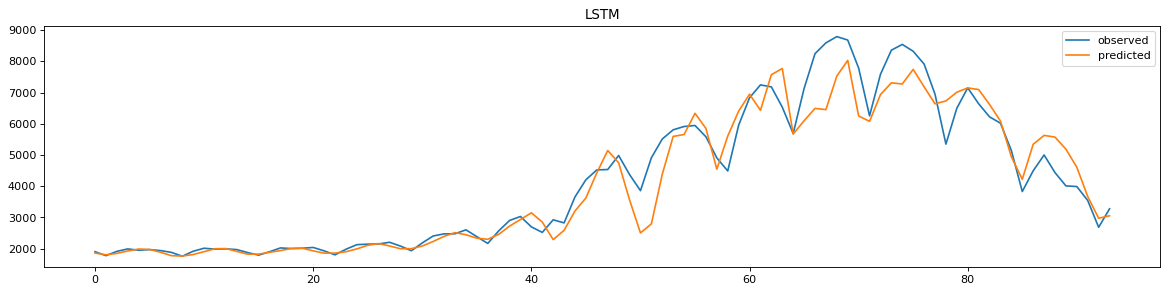

In [44]:
from matplotlib.pyplot import figure
figure(figsize=(18, 4), dpi=80)

plt.plot(y_test_reshape[:,0], label='observed')
plt.plot(y_pred_gru[:,0], label='predicted')
plt.title('LSTM')
plt.legend()
plt.show()

In [45]:
mean_squared_error(y_test_reshape, y_pred)

39706034.98121187

In [46]:
df[-14:]

,Date,Infected
597,2021-09-04,15997.0
598,2021-09-05,12890.0
599,2021-09-06,8223.0
600,2021-09-07,10586.0
601,2021-09-08,12384.0
602,2021-09-09,10378.0
603,2021-09-10,8869.0
604,2021-09-11,8793.0
605,2021-09-12,7204.0
606,2021-09-13,4161.0


### Rescaling input before feeding to model

In [47]:
x_input = np.array([8793.0,7204.0,4161.0,6262, 6799, 5692, 5091, 4692, 3395, 2219, 1758, 3229, 3598, 2085])

In [48]:
#x_input = np.array(df['Infected'][-14:]) # the lastest 14 days
x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
x_input = x_input.reshape((1, n_steps_in, 1))
print(x_input.shape)

(1, 14, 1)


In [63]:
y_pred2 = model_gru.predict(x_input)
y_pred2 = sc.inverse_transform(y_pred2) #revert scaling

In [64]:
y_pred2.shape

(1, 4)

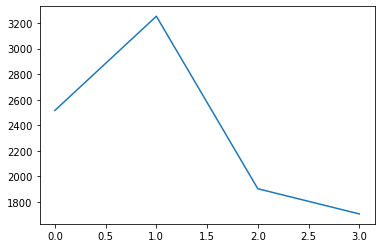

In [65]:
plt.plot(y_pred2[0,:])

In [66]:
x_input_raw = np.array([8793.0,7204.0,4161.0,6262, 6799, 5692, 5091, 4692, 3395, 2219, 1758, 3229, 3598, 2085])
len(x_input_raw)

14

In [67]:
time_range = pd.date_range(start='2021-09-11', end='2021-09-28')

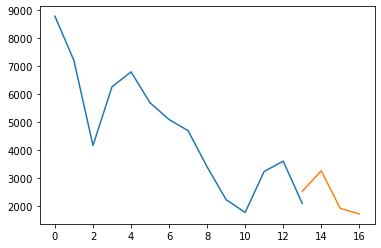

In [68]:
len_x_input = len(x_input_raw)
plt.plot(range(0,len_x_input),x_input_raw)
plt.plot(range(len_x_input-1, len_x_input+n_steps_out-1), y_pred2[0,:])


In [69]:
 y_pred2[0,:]

array([2516.2188, 3252.252 , 1903.8376, 1707.1584], dtype=float32)